# Intro

Some experiments to get a good score for the [Identify Age-Related Conditions][0] kaggle competition using decision tree models.

Start by importing commonly used modules that make it convenient to work with the fastai library. Some will be patched to make them work in non-standard ways but improve interactivity.

[0]: https://www.kaggle.com/competitions/icr-identify-age-related-conditions

In [1]:
from fastai.imports import *
from fastai.tabular.all import *

# Data Inspection

Get the dataset appropriately whether we're in kaggle or not. If in kaggle, it is assumed the competition dataset has been connected to the notebook.

In [2]:
import os
competition_name = "icr-identify-age-related-conditions"

is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if is_kaggle:
    path = Path(f"/kaggle/input/{competition_name}")
else:
    import zipfile, kaggle
    path = Path.home() / '.kaggle' / 'input' / competition_name
    kaggle.api.competition_download_cli(competition_name, path=path.parent)
    zipfile.ZipFile(f'{path}.zip').extractall(path)

icr-identify-age-related-conditions.zip: Skipping, found more recently modified local copy (use --force to force download)


Load the datasets. It's a small dataset so we can set the `low_memory` pandas flag to `False`.

In [3]:
path.ls()

(#4) [Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/test.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/greeks.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/train.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')]

In [4]:
df_train = pd.read_csv(f'{path}/train.csv', low_memory=False)
df_test = pd.read_csv(f'{path}/test.csv', low_memory=False)
df_train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [5]:
df_train.columns

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')

We can now examine the data.

In [6]:
df_train.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


We see that the mean of the dependant column `Class` is much closer to zero than one. This means that the observations with a positive diagnosis are smaller in proportion in the training data. We confirm this by plotting a pie chart for column `Class`.

<Axes: ylabel='count'>

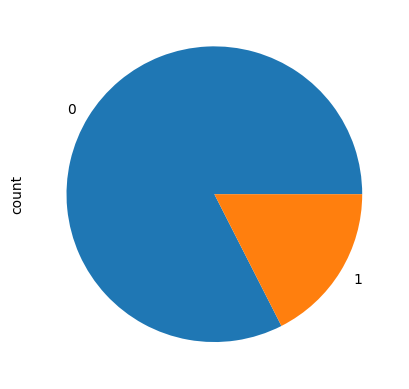

In [7]:
%matplotlib inline

df_train.Class.value_counts().plot.pie()

We also check for null values

In [8]:
df_train.isna().sum()

Id        0
AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

 # Data Processing
 
We'll do some simple processing. We'll replace null values with the mode of their columns, and replace the categorical columns `EJ` and `Id` with numeric codes representing their levels.

In [10]:
modes = df_train.mode().iloc[0]

def process_data(df):
    df.fillna(modes, inplace=True)
    df["EJ"] = pd.Categorical(df.EJ).codes
    df["Id"] = pd.Categorical(df.Id).codes

    
process_data(df_train)
process_data(df_test)

Though the dataset is small we'll do a simple split on the dataframe for model training and validation datasets just to get some initial metrics.

In [11]:
from sklearn.model_selection import train_test_split

train_xy, valid_xy = train_test_split(df_train, test_size=0.25)
train_xy.shape, valid_xy.shape

((462, 58), (155, 58))

Next, split each of our model training and validation sets to X and y values

In [13]:
ycol = "Class"
xcols = [col for col in train_xy.columns if not col == ycol]

def x_y(df):
    return df[xcols], df[ycol]

xs, y = x_y(train_xy)
valid_xs, valid_y = x_y(valid_xy)

In [15]:
# Modelling

We can then create a simple decision tree.

In [16]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

tree = DecisionTreeClassifier(max_leaf_nodes=4)
tree.fit(xs, y)

DecisionTreeClassifier(max_leaf_nodes=4)

In [18]:
import graphviz

def draw_tree(tree, df, size=10, ratio=0.6, precision=2, **kwargs):
    dot_format = export_graphviz(tree, out_file=None, feature_names=xs.columns, filled=True, rounded=True,
                                special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', dot_format))

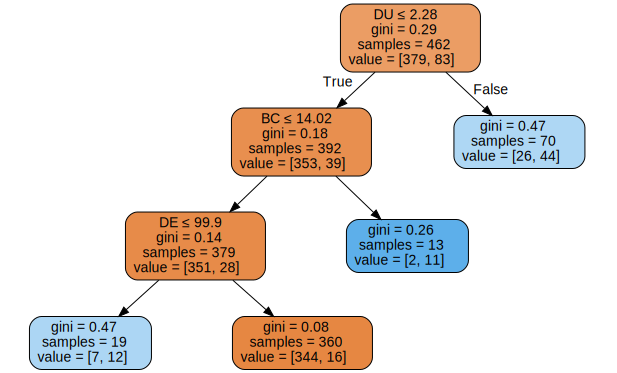

In [19]:
draw_tree(tree, xs)

The competition uses the balanced log loss metric which is explained more [here][0]. For our we'll use the simple implementation.

[0]: https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/422442

In [20]:
from sklearn.metrics import log_loss
def balanced_log_loss(y_true, y_pred):
    nc = np.bincount(y_true)
    return log_loss(y_true, y_pred, sample_weight = 1/nc[y_true], eps=1e-15)

def m_log_loss(model, xs, y): return balanced_log_loss(np.array(y), np.array(model.predict(xs)))

In [21]:
m_log_loss(tree, xs, y), m_log_loss(tree, valid_xs, valid_y)

(4.923873991742516, 6.29671844880961)

The important metric is the one on the validation set, but including the training one as well just to see how it fits the training data.

The log loss is ~ 6.2 with the small tree. We can try a larger tree as well without any restrictions.

In [22]:
tree = DecisionTreeClassifier()
tree.fit(xs, y)

m_log_loss(tree, xs, y), m_log_loss(tree, valid_xs, valid_y)

(9.992007221626413e-16, 8.528442468212607)

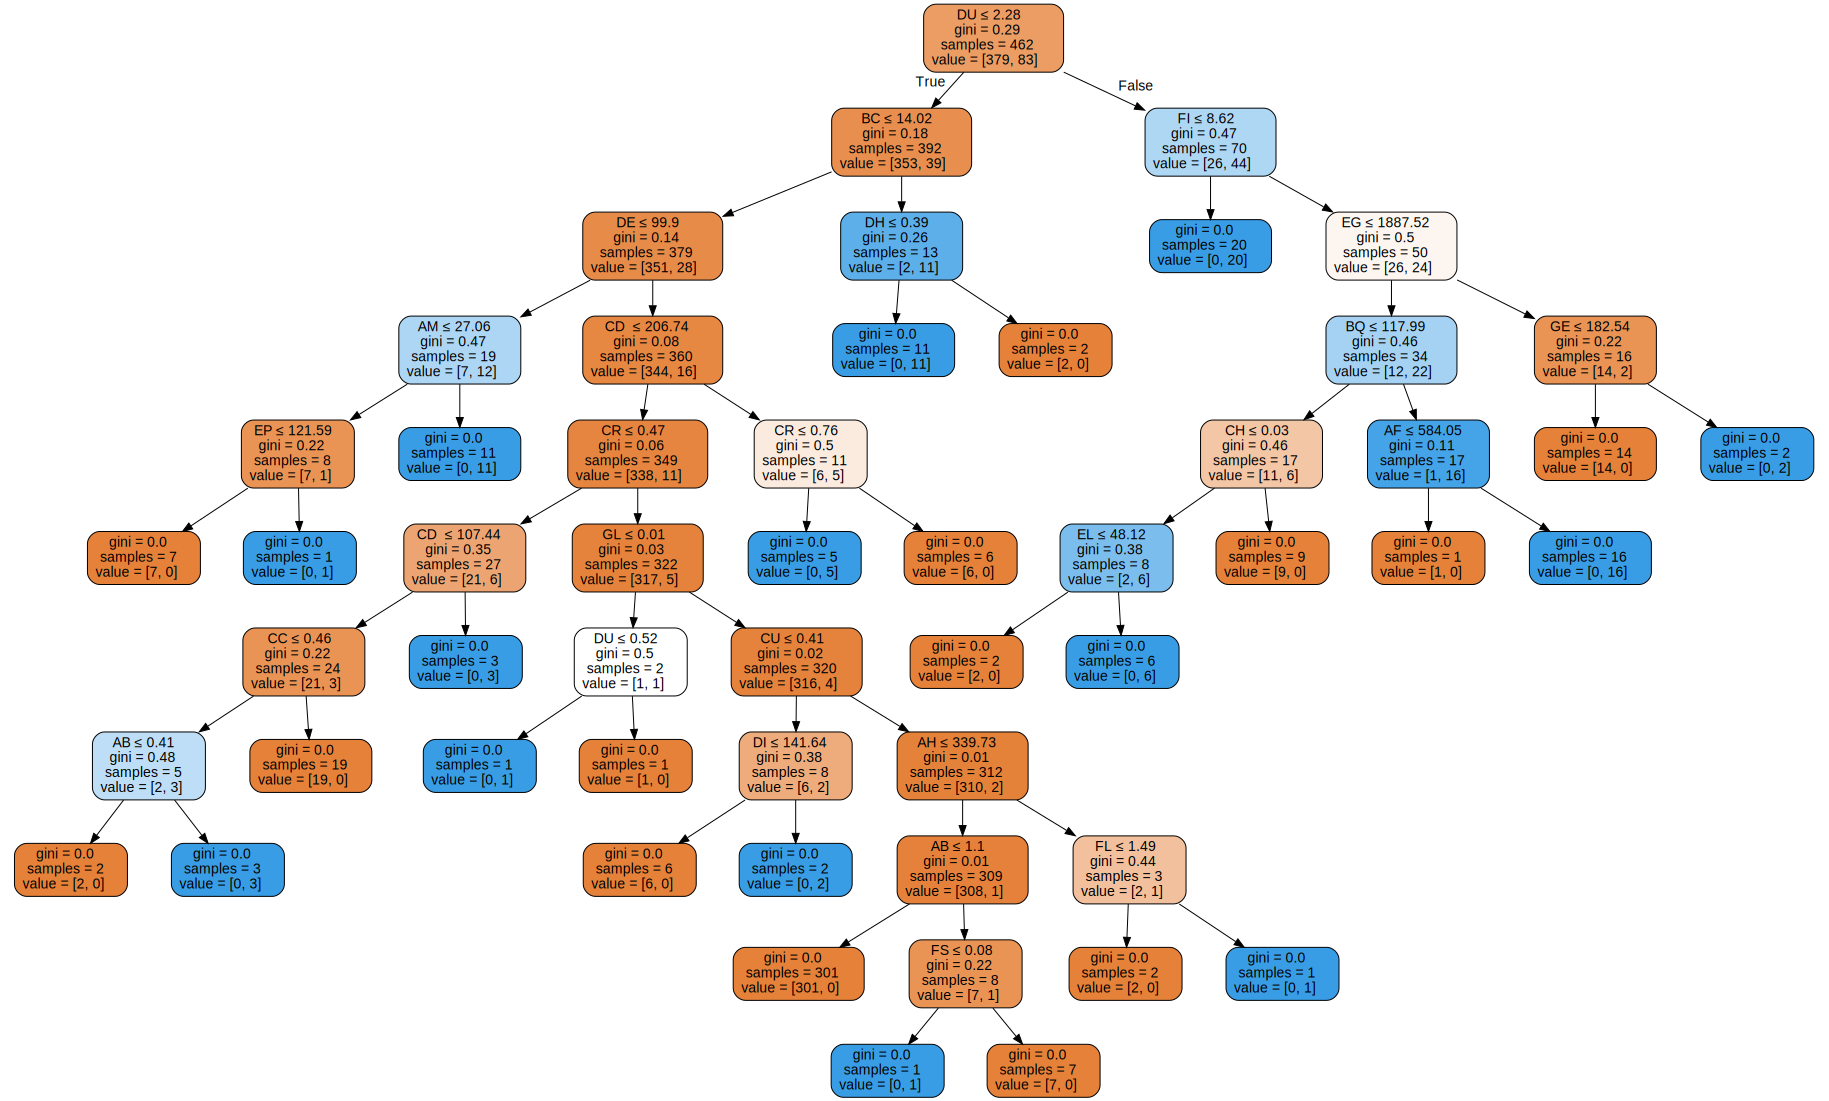

In [23]:
draw_tree(tree, xs, ratio=0.6, size=50)

Seems to overfit.

Or maybe specify min samples per node to reduce overfitting

In [24]:
tree = DecisionTreeClassifier(min_samples_leaf=25)
tree.fit(xs, y)

m_log_loss(tree, xs, y), m_log_loss(tree, valid_xs, valid_y)

(12.36696361034629, 11.876028497317098)

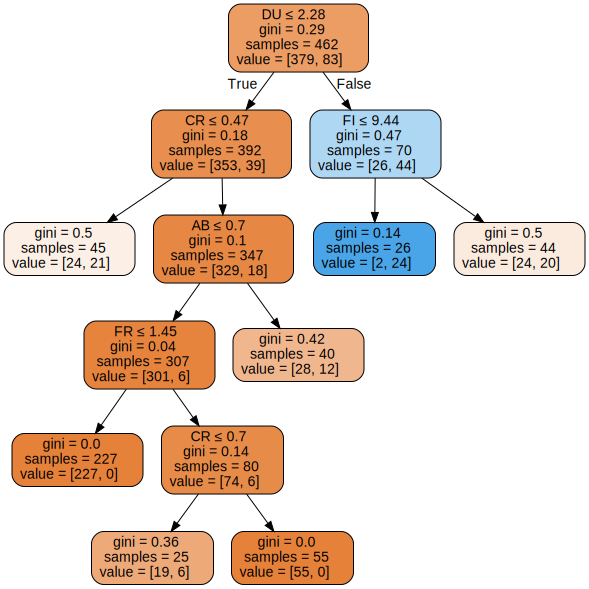

In [25]:
draw_tree(tree, xs, ratio=1)

We can try Random Forests as well to see if there's any improvement.

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(xs, y)

m_log_loss(rf, xs, y), m_log_loss(rf, valid_xs, valid_y)

(9.992007221626413e-16, 3.719566685585999)

Random forest with custom parameters.

In [27]:
def random_forest(xs, y, n_estimators=160, max_samples=0.75, max_features="sqrt", min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        **kwargs
    ).fit(xs, y)

rf = random_forest(xs, y)

In [28]:
m_log_loss(rf, xs, y), m_log_loss(rf, valid_xs, valid_y)

(3.3290386886660905, 7.173444325077067)

Let's see how the OOB predictions compare.

In [29]:
rf = random_forest(xs, y, oob_score=True)

oob_preds = rf.oob_decision_function_
oob_preds_class_1 = oob_preds[:,1]
balanced_log_loss(y, oob_preds_class_1)

0.519734285734023

The OOB predictions look quite good. Since our dataset is quite small, we can inspect the OOB metrics for the complete training dataset.

In [31]:
full_xs, full_y = x_y(df_train)
full_xs.shape, full_y.shape

((617, 57), (617,))

In [32]:
rf = random_forest(full_xs, full_y, oob_score=True)

oob_preds = rf.oob_decision_function_
oob_preds_class_1 = oob_preds[:,1]

balanced_log_loss(full_y, oob_preds_class_1)

0.5002030094589318

# Submission

Looks slightly better with the full training dataset. We can submit to kaggle and see whether there are any improvements over previous submissions.

We need to submit probabilities of each observation being in each class, so we'll use `predict_proba`

In [33]:
if is_kaggle:
    test_probs = rf.predict_proba(df_test[xcols])
    df_submission = pd.read_csv(f"{path}/sample_submission.csv")
    df_submission[["class_0", "class_1"]] = test_probs
    df_submission.to_csv("submission.csv", index=False)